In [68]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# analysis

In [69]:
h3_l7_df = pd.read_json("h3_l7_df.json", orient="records", lines=True)

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
normalized_h3_l7_df = h3_l7_df.drop('id', axis=1)
normalized_h3_l7_df = normalized_h3_l7_df.drop('police', axis=1)

# 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_h3_l7_df = (normalized_h3_l7_df - normalized_h3_l7_df.min()) / (normalized_h3_l7_df.max() - normalized_h3_l7_df.min())


X =  normalized_h3_l7_df.iloc[:,:-1]    # data without ID and OHCA
y =  normalized_h3_l7_df.iloc[:, -1]           # 標籤
# 增加常數項以包含截距
X = sm.add_constant(X)

In [70]:
# 建立線性回歸模型
mod = sm.OLS(y, X, missing='drop')
results = mod.fit()

#X內部相關性分析
correlation = X.corr()

# 輸出結果
print(correlation)

                   const    school   parking  grave_yard   college  hospital  \
const                NaN       NaN       NaN         NaN       NaN       NaN   
school               NaN  1.000000  0.126022    0.049189 -0.025629  0.168831   
parking              NaN  0.126022  1.000000    0.185771  0.152556  0.149093   
grave_yard           NaN  0.049189  0.185771    1.000000  0.252900  0.199101   
college              NaN -0.025629  0.152556    0.252900  1.000000  0.397627   
hospital             NaN  0.168831  0.149093    0.199101  0.397627  1.000000   
fuel                 NaN  0.289435  0.302063    0.017667  0.129317  0.238310   
place_of_worship     NaN  0.482807  0.182392    0.105678  0.003727  0.130128   
fast_food            NaN  0.358263  0.362355   -0.030391 -0.028708  0.227063   
stage                NaN  0.075880  0.441853   -0.014029 -0.010437 -0.012830   
restaurant           NaN  0.278820  0.547833   -0.048429 -0.013795  0.058966   
university           NaN  0.026810  0.14

In [71]:
# 輸出結果
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   ohca   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     11.05
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           7.10e-22
Time:                        22:13:09   Log-Likelihood:                 132.51
No. Observations:                 137   AIC:                            -175.0
Df Residuals:                      92   BIC:                            -43.62
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0503      0.01

# regression

In [72]:
import random

# 設定訓練、驗證和測試集的比例
train_proportion = 0.7   

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
normalized_h3_l7_df = h3_l7_df.drop('id', axis=1)
normalized_h3_l7_df = normalized_h3_l7_df.drop('police', axis=1)

# 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_h3_l7_df = (normalized_h3_l7_df - normalized_h3_l7_df.min()) / (normalized_h3_l7_df.max() - normalized_h3_l7_df.min())

# 設定隨機種子並打亂數據
seed = 136515
np.random.seed(seed)
random.seed(seed)

# 將數據轉換成 numpy array 並打亂
h3_l7_id = np.random.choice(normalized_h3_l7_df.shape[0], normalized_h3_l7_df.shape[0], replace=False)
spatial_data = normalized_h3_l7_df.iloc[h3_l7_id].to_numpy()

# 分割訓練和測試數據集
train_size = int(spatial_data.shape[0] * train_proportion)
train_spatial_data = spatial_data[:train_size, :]
test_spatial_data = spatial_data[train_size:, :]

# 分離特徵和標籤
X_train = train_spatial_data[:, :-1]   # features
y_train = train_spatial_data[:, -1]    # target
X_test = test_spatial_data[:, :-1]
y_test = test_spatial_data[:, -1]

# 增加常數項以包含截距
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# 建立線性回歸模型
mod = sm.OLS(y_train, X_train, missing='drop')
res = mod.fit()

# 輸出結果
print("訓練結果：")
print(res.summary())

訓練結果：
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     9.695
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           1.10e-13
Time:                        22:13:09   Log-Likelihood:                 106.96
No. Observations:                  95   AIC:                            -129.9
Df Residuals:                      53   BIC:                            -22.65
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0503      0.019      2.697   

In [73]:
# 使用模型進行預測
y_pred_train = res.predict(X_train)
#返回正規化前的值
y_pred_train = y_pred_train*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()
y_train = y_train*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 計算測試集上的均方誤差
mae = np.abs(y_pred_train-y_train)
mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',mae)

# 計算殘差變異
ss_residual = np.sum((y_train - y_pred_train) ** 2)

# 計算總變異量
ss_total = np.sum((y_train - np.mean(y_train)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

print("R² of test set= ", r_squared)

MAE of test set=  3.7282570240830757
R² of test set=  0.8823475781870562


In [74]:
# 使用模型進行預測
y_pred_test = res.predict(X_test)
#返回正規化前的值
y_pred_test = y_pred_test*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()
y_test = y_test*(h3_l7_df.ohca.max()- h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 計算測試集上的均方誤差
mae = np.abs(y_pred_test-y_test)
mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_pred_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

print("R² of test set= ", r_squared)

MAE of test set=  12.200279068732348
R² of test set=  -0.6190776915857461


Text(0, 0.5, 'Reality')

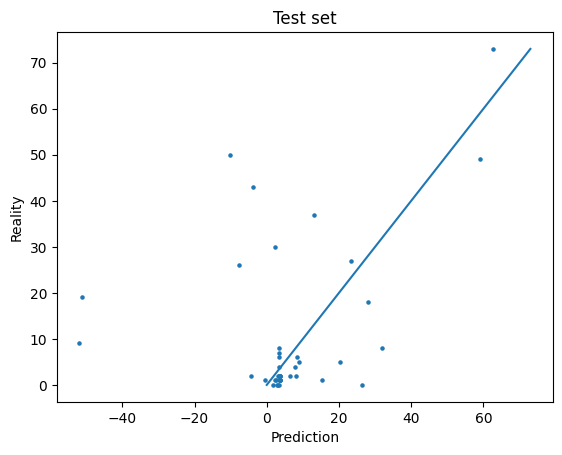

In [75]:
plt.scatter(y_pred_test,
            y_test,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')